# Stout Case Study #1: Loans data

*First, we import useful libraries and load the data.*

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
loans = pd.read_csv("/content/drive/MyDrive/Stout/loans_full_schema.csv")

## 1) Describe the dataset and any issues with it

In [15]:
loans.shape

(10000, 55)

The dataset contains 10,000 rows and describes 55 features.

In [6]:
loans.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,0,38.0,2001,6,28,10,70795,38767,0,0,38.0,0,1250,2,5,5.0,10,0.0,0,2,11100,14,8,6,1,92.9,0,0,moving,individual,28000,60,14.07,652.53,C,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,0,NaN,1996,1,30,14,28800,4321,0,1,NaN,0,0,0,11,8.0,14,0.0,0,3,16500,24,14,4,0,100.0,0,1,debt_consolidation,individual,5000,36,12.61,167.54,C,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,0,28.0,2006,4,31,10,24193,16000,0,0,28.0,0,432,1,13,7.0,10,0.0,0,3,4300,14,8,6,0,93.5,0,0,other,individual,2000,36,17.09,71.40,D,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,0,NaN,2007,0,4,4,25400,4997,0,1,NaN,0,0,1,1,15.0,4,0.0,0,2,19400,3,3,2,0,100.0,1,0,debt_consolidation,individual,21600,36,6.72,664.19,A,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,0,NaN,2008,7,22,16,69839,52722,0,0,NaN,0,0,1,6,4.0,16,0.0,0,10,32700,20,15,13,0,100.0,0,0,credit_card,joint,23000,36,14.07,786.87,C,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


In [7]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         9167 non-null   object 
 1   emp_length                        9183 non-null   float64
 2   state                             10000 non-null  object 
 3   homeownership                     10000 non-null  object 
 4   annual_income                     10000 non-null  float64
 5   verified_income                   10000 non-null  object 
 6   debt_to_income                    9976 non-null   float64
 7   annual_income_joint               1495 non-null   float64
 8   verification_income_joint         1455 non-null   object 
 9   debt_to_income_joint              1495 non-null   float64
 10  delinq_2y                         10000 non-null  int64  
 11  months_since_last_delinq          4342 non-null   float64
 12  earli

Here we have information on the distribution of each numerical variable: count, mean, std, min, max and quantiles. 

In [8]:
loans.describe()

,emp_length,annual_income,debt_to_income,annual_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
count,9183.000000,1.000000e+04,9976.000000,1.495000e+03,1495.000000,10000.00000,4342.000000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,2285.000000,10000.0000,10000.000000,10000.000000,10000.000000,8729.000000,10000.000000,9682.0,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.930306,7.922215e+04,19.308192,1.279146e+05,19.979304,0.21600,36.760709,2001.29000,1.95820,22.679600,11.40440,1.836062e+05,51049.063100,0.013800,0.167100,46.112473,0.0001,184.334000,2.663600,4.376100,7.340703,11.379600,0.0,0.0001,3.595300,27357.410300,13.030000,8.095000,5.230500,1.383100,94.648990,0.043300,0.123800,16361.922500,43.272000,12.427524,476.205323,14458.916610,2494.234773,1894.448466,599.666781,0.119516
std,3.703734,6.473429e+04,15.004851,7.016838e+04,8.054781,0.68366,21.634939,7.79551,2.38013,11.885439,5.86828,1.876327e+05,53636.731172,0.126535,0.687768,21.748021,0.0100,2206.389859,2.935387,3.158583,5.981590,5.859705,0.0,0.0100,2.434689,26570.164081,7.874713,4.906606,3.327623,1.717274,9.155059,0.593852,0.337172,10301.956759,11.029877,5.001105,294.851627,9964.561865,3958.230365,3884.407175,517.328062,1.813468
min,0.000000,0.000000e+00,0.000000,1.920000e+04,0.320000,0.00000,1.000000,1963.00000,0.00000,2.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,2.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,14.300000,0.000000,0.000000,1000.000000,36.000000,5.310000,30.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,4.500000e+04,11.057500,8.683350e+04,14.160000,0.00000,19.000000,1997.00000,0.00000,14.000000,7.00000,5.159375e+04,19185.500000,0.000000,0.000000,29.000000,0.0000,0.000000,1.000000,2.000000,2.000000,7.000000,0.0,0.0000,2.000000,10000.000000,7.000000,5.000000,3.000000,0.000000,92.600000,0.000000,0.000000,8000.000000,36.000000,9.430000,256.040000,6679.065000,928.700000,587.100000,221.757500,0.000000
50%,6.000000,6.500000e+04,17.570000,1.130000e+05,19.720000,0.00000,34.000000,2003.00000,1.00000,21.000000,10.00000,1.146670e+05,36927.000000,0.000000,0.000000,47.000000,0.0000,0.000000,2.000000,4.000000,6.000000,10.000000,0.0,0.0000,3.000000,19500.000000,11.000000,7.000000,5.000000,1.000000,100.000000,0.000000,0.000000,14500.000000,36.000000,11.980000,398.420000,12379.495000,1563.300000,984.990000,446.140000,0.000000
75%,10.000000,9.500000e+04,25.002500,1.515455e+05,25.500000,0.00000,53.000000,2006.00000,3.00000,29.000000,14.00000,2.675500e+05,65421.000000,0.000000,0.000000,63.000000,0.0000,0.000000,3.000000,6.000000,11.000000,14.000000,0.0,0.0000,5.000000,36100.000000,17.000000,10.000000,7.000000,2.000000,100.000000,0.000000,0.000000,24000.000000,60.000000,15.050000,644.690000,20690.182500,2616.005000,1694.555000,825.420000,0.000000
max,10.000000,2.300000e+06,469.090000,1.100000e+06,39.980000,13.00000,118.000000,2015.00000,29.00000,87.000000,51.00000,3.386034e+06,942456.000000,3.000000,52.

Then we compute the percentage of missing values for each variable:

In [14]:
loans.isnull( ).sum( )/len(loans)*100

emp_title                            8.33
emp_length                           8.17
state                                0.00
homeownership                        0.00
annual_income                        0.00
verified_income                      0.00
debt_to_income                       0.24
annual_income_joint                 85.05
verification_income_joint           85.45
debt_to_income_joint                85.05
delinq_2y                            0.00
months_since_last_delinq            56.58
earliest_credit_line                 0.00
inquiries_last_12m                   0.00
total_credit_lines                   0.00
open_credit_lines                    0.00
total_credit_limit                   0.00
total_credit_utilized                0.00
num_collections_last_12m             0.00
num_historical_failed_to_pay         0.00
months_since_90d_late               77.15
current_accounts_delinq              0.00
total_collection_amount_ever         0.00
current_installment_accounts      

The most problematic features are:
- `verification_income_joint`(Type of verification of the joint income): 85.45% of missing values 
- `annual_income_joint` (If this is a joint application, then the annual income of the two parties applying.): 85.05% of missing values
- `debt_to_income_joint`(Debt-to-income ratio for the two parties.): 85.05% of missing values
- `months_since_90d_late`(Months since the last time the applicant was 90 days late on a payment.): 77.15% of missing values
- `months_since_last_delinq`(Months since the last delinquency.): 56.58% of missing values




We also have missing values for the following features, but at a lesser extent:
- `months_since_last_credit_inquiry`(Number of months since the last credit inquiry on this applicant.): 12.71% of missing values
- `emp_title`(Job title.): 8.33% of missing values
- `emp_length`(emp_length): 8.17% of missing values


The main reason why there are so many missing values for the features ending with 'joint' is that they concerns people who are not part of a joint account, so the data for these variable are not known. 
For the other missing values, it appears that the reason is also because the feature does not apply to the person that the row is describing. (e.g. for `months_since_last_credit_inquiry`, when the value is missing, it may be because this person has never experienced a credit inquiry.

Below is the number of unique values for each feature:

In [16]:
loans.nunique( )

emp_title                           4741
emp_length                            11
state                                 50
homeownership                          3
annual_income                       1463
verified_income                        3
debt_to_income                      3673
annual_income_joint                  596
verification_income_joint              3
debt_to_income_joint                1189
delinq_2y                             12
months_since_last_delinq              97
earliest_credit_line                  53
inquiries_last_12m                    26
total_credit_lines                    78
open_credit_lines                     45
total_credit_limit                  9119
total_credit_utilized               9497
num_collections_last_12m               4
num_historical_failed_to_pay           9
months_since_90d_late                106
current_accounts_delinq                2
total_collection_amount_ever         896
current_installment_accounts          30
accounts_opened_

In [46]:
loans.emp_title.value_counts()

manager                                  218
owner                                    204
teacher                                  201
driver                                   123
sales                                     97
                                        ... 
5th year apprentice                        1
mechanical designer                        1
executive producer/on-air personality      1
legal advisor                              1
caretaker                                  1
Name: emp_title, Length: 4741, dtype: int64

Overall, the dataset seems quite clean: no outlier points, just some missing values due to rows that are not all applicable on the corresponding feature. If we need to replace the missing values by others, we will do it next.

## 2)Generate a minimum of 5 unique visualizations using the data and write a brief description of your observations. 

First is plotted the distribution of the `annual_income`:

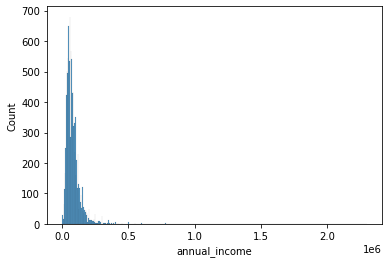

In [18]:
sns.histplot(data=loans,x="annual_income")

We can see on this histogram that the distribution of the annual income is right skewed.

Then is plotted the annual income against the interest rate for several combinations of loan status and application type.. 

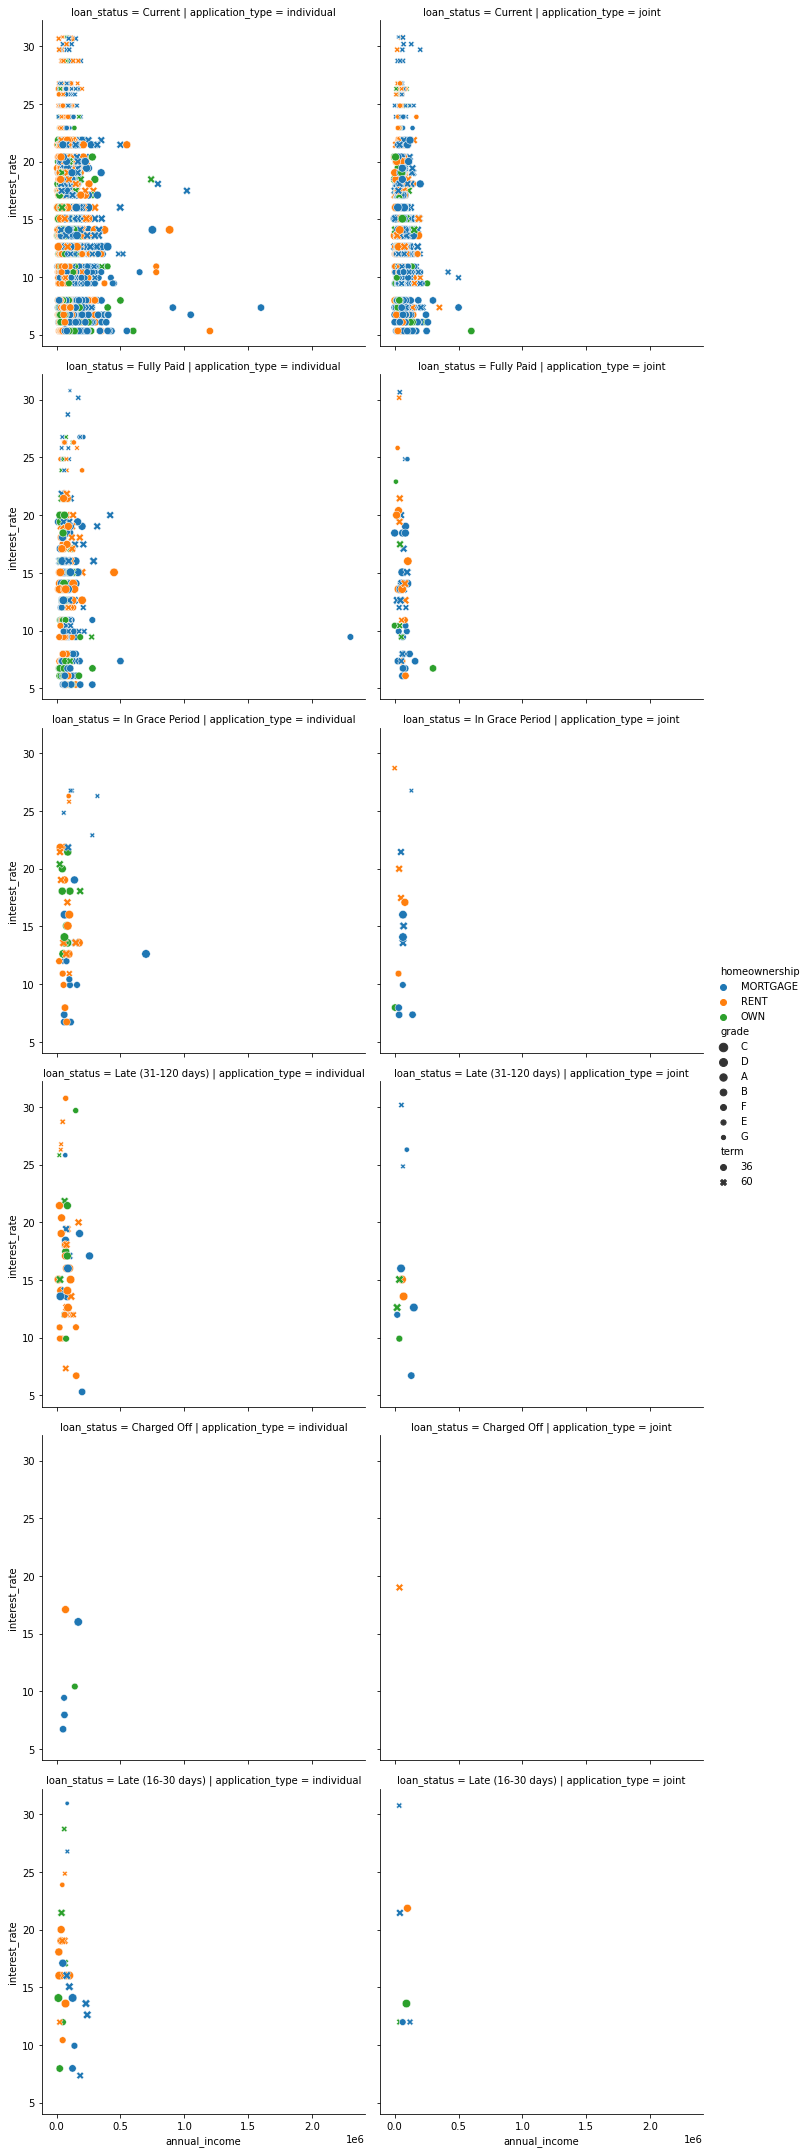

In [23]:
fg = sns.relplot(x="annual_income", y="interest_rate", data=loans, kind="scatter",
            hue="homeownership", size="grade", 
            col='application_type', row='loan_status', style='term',
            )

The main takeaway here is that for a small range of annual income, the interest rate is taking a wide range of values.

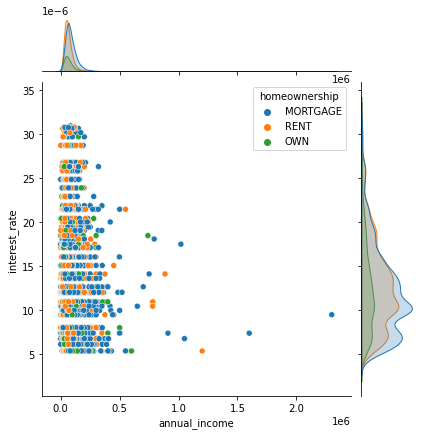

In [32]:
jp = sns.jointplot("annual_income", "interest_rate", hue = "homeownership",data=loans)

It appears here that the people who own their house have a much more uniform distributino of the interest rate. 

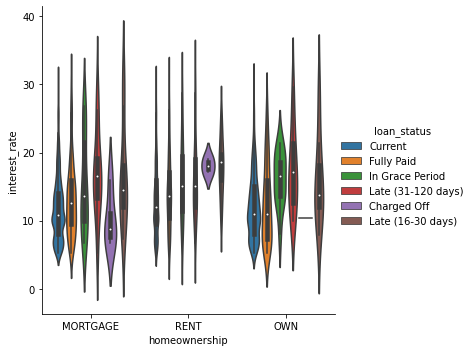

In [30]:
cp1 = sns.catplot(x="homeownership", y="interest_rate", hue="loan_status", data=loans, kind="violin", 
            jitter=False, dodge=True)

In the violin plot above, we can see that for mortgage homeownership, the value of the interest rate is much more widely distributed than for rent and own status. Moreover, the "current" loan status, with "charged off", seem to have a bell shaped distribution of the interest rate, compared to the other status.

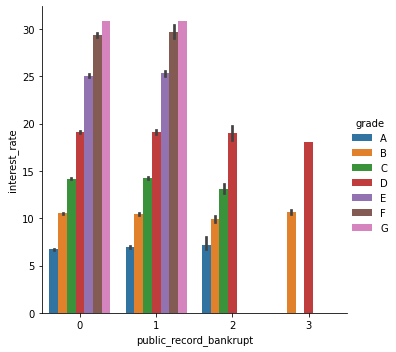

In [33]:
cp2 = sns.catplot(x="public_record_bankrupt", y="interest_rate", hue="grade", data=loans, kind="bar",hue_order=["A","B","C","D","E","F","G"])

Finally, this bar plot clearly shows that the better the grade is, the lower the interest_rate here, regardless of the public_record_bankrupt.

## 3) Create a feature set and create a model which predicts interest rate using at least 2 algorithms. Describe any data cleansing that must be performed and analysis when examining the data.

### Feature selection

We divide the features between numerical and categorical.
We fill the missing values with 0 in order to keep the rows that contains this information.

In [77]:
loans=loans.fillna(0)

first_column = loans.pop('interest_rate')

loans_numerical = loans.select_dtypes(include=['int64','float64'])
loans_numerical

loans_categorical = loans.select_dtypes(include="object")
loans_categorical_one_hot = pd.get_dummies(loans_categorical)
loans_categorical_one_hot

loans_train = pd.concat([loans_numerical,loans_categorical_one_hot],axis=1)

In [107]:
X_num = loans_numerical.values
X_cat = loans_categorical_one_hot.values
Y = first_column.values.astype('int')

For both types of features, we select the 20 best scores for the chi2 test.
Below are the names of the features kept for training, for both type of data.

In [108]:
from sklearn.feature_selection import SelectKBest,chi2

In [109]:
Selector_numerical= SelectKBest(chi2, k=25)
X_num_selected=Selector_numerical.fit_transform(X_num, Y)
features_numerical = loans_numerical.columns.values[Selector_numerical.get_support()]
features_numerical

array(['annual_income', 'debt_to_income', 'annual_income_joint',
       'debt_to_income_joint', 'delinq_2y', 'months_since_last_delinq',
       'inquiries_last_12m', 'total_credit_lines', 'total_credit_limit',
       'total_credit_utilized', 'months_since_90d_late',
       'total_collection_amount_ever', 'accounts_opened_24m',
       'months_since_last_credit_inquiry', 'total_debit_limit',
       'num_total_cc_accounts', 'num_mort_accounts', 'loan_amount',
       'term', 'installment', 'balance', 'paid_total', 'paid_principal',
       'paid_interest', 'paid_late_fees'], dtype=object)

In [110]:
Selector_categorical= SelectKBest(chi2, k=25)
X_cat_selected=Selector_categorical.fit_transform(X_cat, Y)
features_categorical = loans_categorical_one_hot.columns.values[Selector_categorical.get_support()]
features_categorical

array(['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'sub_grade_A1', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2'], dtype=object)

In [117]:
X=np.concatenate([X_num_selected,X_cat_selected],axis=1)
X.shape

(10000, 50)

In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [120]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.9939701378966109

In [142]:
from sklearn.linear_model import Ridge
clf=Ridge(alpha=0.1).fit(X_train, y_train)
clf.score(X_test,y_test)

0.9939329678647429

In [124]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200).fit(X_train, y_train)
rf.score(X_test, y_test)

0.994936140931689

Here we used three algorithms for predicting the interest rate:
- a Linear Regression model
- a Ridge Regression with $\lambda =0.1$ 
- a Random Forest Regressor, an ensemble algorithm with 200 estimators

The algorithm with the best score on the test data is the **Random Forest algorithm**, with a score of **99.49%** on the test data.

### 4) Visualize the test results and propose enhancements to the model, what would you do if you had more time. Also describe assumptions you made and your approach.

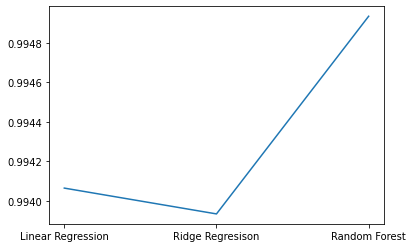

In [153]:
import matplotlib.pyplot as plt
plt.plot(["Linear Regression","Ridge Regresison","Random Forest"],[reg.score(X_test, y_test),clf.score(X_test,y_test),rf.score(X_test, y_test)])

To enhance the model, I could think about other algorithms, such as neural networks (MultiLayer Perceptron) or even using cross-validation for finding a better lambda for Ridge Regression.

A major assumption was the use of the most inluential feature regarding the chi2 test. I could have used more features if I had more time.
Another assumption was the fact of replacing the missing values with 0. We could have dropped those rows for a better accuracy but I wanted to keep the information related to these rows.